<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Statistics-and-Machine-Learning/blob/main/DA1_C2_Part1_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2 - Part 1
**Professor für Data Science: Prof. Dr. Mehrdad Jalali**  

This unified notebook merges your uploaded Day 6–8 materials and adds self‑contained, runnable examples aligned with the slide deck topics (data preprocessing & quality, feature engineering/selection, regression, classification, evaluation).  
It is organized to be used as **one master file** for class and self‑study.

---

## Table of Contents
1. [Environment Setup](#env-setup)
2. [Data Quality & Preprocessing](#preprocessing)
   - Missing Values (Simple & Model-Based Imputation)
   - Noise vs Outliers (Detection & Handling)
   - Scaling (Standardization & Min–Max)
   - Encoding (One‑Hot)
3. [Feature Engineering](#feature-eng)
   - Transformations, Interaction, Binning, Datetime
4. [Feature Selection](#feature-select)
   - Filter (Correlation, Mutual Information)
   - Wrapper (RFE: Forward/Backward intuition)
   - Embedded (Lasso / Tree-Based)
5. [Supervised Learning: Regression](#regression)
   - Linear / Polynomial / Logistic Regression
   - Holdout vs K‑Fold
   - Metrics: RMSE, R²
6. [Supervised Learning: Classification](#classification)
   - Decision Tree, Random Forest, Gradient Boosting
   - KNN (choosing *k*)
   - Confusion Matrix & Metrics (Accuracy, Precision, Recall, F1)
7. [Imported Code & Notes from Your Notebooks](#imports)
   - Day 6
   - Day 6 (Embedded)
   - Day 7
   - Day 8
8. [Appendix: Utility Helpers](#appendix)

> **Tip:** You can collapse sections in Jupyter by clicking on the markdown headers.


## 1) Environment Setup <a id='env-setup'></a>

In [1]:
# Core scientific stack (offline-friendly)
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Sklearn (models, metrics, preprocessing, selection)
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, mutual_info_classif, mutual_info_regression
from sklearn.datasets import make_regression, make_classification, load_wine, load_breast_cancer

# Tree-based & boosting models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Utils
rng = np.random.RandomState(42)
print('Environment ready.')

Environment ready.


## 2) Data Quality & Preprocessing <a id='preprocessing'></a>

### 2.1 Missing Values — Simple & Model-Based Imputation
We create a small mixed-type dataset, inject missingness, and show:
- Mean/median/mode imputation (simple).
- KNN imputation (predictive, structure-aware).

In [ ]:
# Create a toy dataset with numeric + categorical columns
df = pd.DataFrame({
    'age': rng.randint(18, 70, size=30).astype(float),
    'income': rng.normal(55000, 12000, size=30),
    'dept': rng.choice(['HR','Engineering','Sales'], size=30),
    'label': rng.choice([0,1], size=30)
})
# Inject some missing values
for col in ['age','income','dept']:
    ix = rng.choice(df.index, size=5, replace=False)
    df.loc[ix, col] = np.nan

print('Original with missing values:')
display(df.head(10))

# Simple imputation: numeric -> mean, categorical -> most_frequent
numeric_cols = ['age','income']
cat_cols = ['dept']

simple_pre = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_cols),
        ('cat', SimpleImputer(strategy='most_frequent'), cat_cols),
    ],
    remainder='drop'
)

df_simple_imputed = pd.DataFrame(
    simple_pre.fit_transform(df),
    columns=numeric_cols + cat_cols
)
print('\nSimple-imputed:')
display(df_simple_imputed.head(10))

# KNN imputation (numeric-only demo): apply to numeric subset
knn_imp = KNNImputer(n_neighbors=3)
num_only = df[numeric_cols]
df_knn_num = pd.DataFrame(knn_imp.fit_transform(num_only), columns=numeric_cols)
print('\nKNN-imputed (numeric subset):')
display(df_knn_num.head(10))

### 2.2 Noise vs Outliers — Detection & Handling
- **Noise**: small random fluctuations (e.g., sensor jitter).  
- **Outliers**: points far from the bulk (e.g., one-off spikes).  
We demonstrate simple smoothing (moving average) for noise and Z-score filtering for outliers.

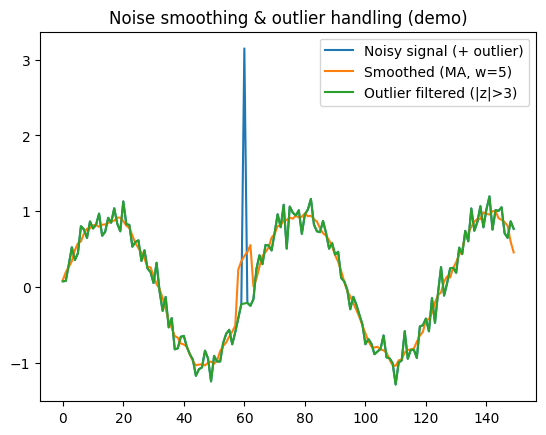

In [2]:
# Simulate time series with noise + an outlier
n = 150
t = np.arange(n)
signal = np.sin(t/10) + rng.normal(0, 0.15, size=n)
signal[60] += 3.5  # one big outlier

# Moving average smoothing (window=5)
def moving_average(x, w=5):
    return np.convolve(x, np.ones(w)/w, mode='same')

smooth = moving_average(signal, 5)

# Z-score outlier removal (simple demo)
z = (signal - signal.mean()) / signal.std(ddof=1)
filtered = signal.copy()
filtered[np.abs(z) > 3] = np.nan  # mark extreme outliers
filtered = pd.Series(filtered).interpolate().to_numpy()

plt.figure()
plt.plot(signal, label='Noisy signal (+ outlier)')
plt.plot(smooth, label='Smoothed (MA, w=5)')
plt.plot(filtered, label='Outlier filtered (|z|>3)')
plt.legend()
plt.title('Noise smoothing & outlier handling (demo)')
plt.show()

### 2.3 Scaling (Standardization & Min–Max)
We compare StandardScaler (Z-score) vs MinMaxScaler on numeric features.

In [3]:
X = pd.DataFrame({
    'credit_score': [720,650,780,600,700,680],
    'income': [60000,45000,75000,30000,80000,55000],
    'age': [25,35,45,23,50,30]
})
print('Original:')
display(X)

std = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
mm  = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns)

print('Standardized (Z-score):'); display(std)
print('Min–Max [0,1]:'); display(mm)

Original:


,credit_score,income,age
0,720,60000,25
1,650,45000,35
2,780,75000,45
3,600,30000,23
4,700,80000,50
5,680,55000,30


Standardized (Z-score):


,credit_score,income,age
0,0.564467,0.146911,-0.972082
1,-0.683302,-0.734553,0.033520
2,1.633984,1.028374,1.039122
3,-1.574566,-1.616017,-1.173203
4,0.207962,1.322196,1.541924
5,-0.148544,-0.146911,-0.469281


Min–Max [0,1]:


,credit_score,income,age
0,0.666667,0.6,0.074074
1,0.277778,0.3,0.444444
2,1.000000,0.9,0.814815
3,0.000000,0.0,0.000000
4,0.555556,1.0,1.000000
5,0.444444,0.5,0.259259


### 2.4 One‑Hot Encoding
We one‑hot encode a categorical column to numeric indicator columns.

In [4]:
X_cat = pd.DataFrame({
    'age':[25,32,47,19,30],
    'dept':['HR','Engineering','HR','Sales','Engineering']
})
X_oh = pd.get_dummies(X_cat, columns=['dept'], drop_first=False)
display(X_cat)
display(X_oh)

,age,dept
0,25,HR
1,32,Engineering
2,47,HR
3,19,Sales
4,30,Engineering


,age,dept_Engineering,dept_HR,dept_Sales
0,25,False,True,False
1,32,True,False,False
2,47,False,True,False
3,19,False,False,True
4,30,True,False,False


## 3) Feature Engineering <a id='feature-eng'></a>

Create new, informative features: transformations, interactions, bins, and datetime extractions.

In [5]:
df_fe = pd.DataFrame({
    'credit_score':[720,650,780,600,700,680],
    'income':[60000,45000,75000,30000,80000,55000],
    'age':[25,35,45,23,50,30],
    'purchase_date': pd.to_datetime(['2022-01-10','2021-12-01','2020-05-15','2023-04-03','2022-07-07','2021-09-20'])
})
df_fe['credit_to_income'] = df_fe['credit_score'] / df_fe['income']
df_fe['income_x_age'] = df_fe['income'] * df_fe['age']
df_fe['age_group'] = pd.cut(df_fe['age'], bins=[18,30,40,50,65], labels=['18-30','31-40','41-50','51-65'])
today = pd.Timestamp('2024-01-01')
df_fe['days_since_purchase'] = (today - df_fe['purchase_date']).dt.days

display(df_fe)

,credit_score,income,age,purchase_date,credit_to_income,income_x_age,age_group,days_since_purchase
0,720,60000,25,2022-01-10,0.012000,1500000,18-30,721
1,650,45000,35,2021-12-01,0.014444,1575000,31-40,761
2,780,75000,45,2020-05-15,0.010400,3375000,41-50,1326
3,600,30000,23,2023-04-03,0.020000,690000,18-30,273
4,700,80000,50,2022-07-07,0.008750,4000000,41-50,543
5,680,55000,30,2021-09-20,0.012364,1650000,18-30,833


## 4) Feature Selection <a id='feature-select'></a>

### 4.1 Filter Methods (Correlation, Mutual Information)
We compute Pearson correlation (for numeric) and mutual information (for non‑linear relations).

In [6]:
# Synthetic regression dataset
Xr, yr = make_regression(n_samples=400, n_features=8, n_informative=4, noise=12, random_state=42)
Xr = pd.DataFrame(Xr, columns=[f'f{i}' for i in range(Xr.shape[1])])

# Correlation with target
corrs = [np.corrcoef(Xr[c], yr)[0,1] for c in Xr.columns]
corr_df = pd.DataFrame({'feature': Xr.columns, 'pearson_r': corrs}).sort_values('pearson_r', key=np.abs, ascending=False)
display(corr_df)

# Mutual information (regression)
mi = mutual_info_regression(Xr, yr, random_state=42)
mi_df = pd.DataFrame({'feature': Xr.columns, 'mutual_info': mi}).sort_values('mutual_info', ascending=False)
display(mi_df)

,feature,pearson_r
1,f1,0.604649
3,f3,0.498078
4,f4,0.452178
2,f2,0.399906
6,f6,-0.036710
5,f5,0.028258
0,f0,-0.012982
7,f7,0.011230


,feature,mutual_info
1,f1,0.214709
3,f3,0.119325
4,f4,0.117211
5,f5,0.056757
6,f6,0.031871
0,f0,0.027612
2,f2,0.013228
7,f7,0.000000


### 4.2 Wrapper Methods (RFE)
Use RFE with LinearRegression for regression and LogisticRegression for classification.

In [7]:
# Regression RFE
lin = LinearRegression()
rfe = RFE(estimator=lin, n_features_to_select=4)
rfe.fit(Xr, yr)
selected_r = [f for f, keep in zip(Xr.columns, rfe.support_) if keep]
print('RFE-selected (regression):', selected_r)

# Classification RFE
Xc, yc = make_classification(n_samples=400, n_features=10, n_informative=4, n_redundant=2, random_state=42)
Xc = pd.DataFrame(Xc, columns=[f'f{i}' for i in range(Xc.shape[1])])
log = LogisticRegression(max_iter=200, n_jobs=None, solver='lbfgs')
rfe_clf = RFE(estimator=log, n_features_to_select=5)
rfe_clf.fit(Xc, yc)
selected_c = [f for f, keep in zip(Xc.columns, rfe_clf.support_) if keep]
print('RFE-selected (classification):', selected_c)

RFE-selected (regression): ['f1', 'f2', 'f3', 'f4']
RFE-selected (classification): ['f0', 'f2', 'f5', 'f6', 'f9']


### 4.3 Embedded Methods (Lasso & Tree-Based)
- **Lasso (L1)** can zero‑out coefficients → implicit selection.  
- **Tree/Ensemble** models expose feature importances during training.

In [9]:
# Lasso for regression feature selection
lasso = Lasso(alpha=0.05, max_iter=10000, random_state=42)
lasso.fit(Xr, yr)
coef = pd.Series(lasso.coef_, index=Xr.columns).sort_values(key=np.abs, ascending=False)
print('Lasso coefficients:')
display(coef)

# RandomForest feature importance (classification)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(Xc, yc)
imp = pd.Series(rf.feature_importances_, index=Xc.columns).sort_values(ascending=False)
print('RandomForest importances:')
display(imp)

Lasso coefficients:


,0
f1,93.928738
f3,81.661805
f4,68.550838
f2,56.416785
f0,0.908738
f7,0.621600
f5,-0.150328
f6,-0.000476


RandomForest importances:


,0
f2,0.183326
f6,0.164701
f5,0.160587
f9,0.123941
f4,0.115412
f3,0.108899
f7,0.037655
f1,0.037080
f0,0.035926
f8,0.032474


## 5) Supervised Learning — Regression <a id='regression'></a>

We compare Linear, Polynomial, and Logistic (as classification) regression tasks.  
Metrics: **RMSE** and **R²**. We also compare **Holdout** vs **K-Fold** validation.

In [11]:
# Synthetic regression data
X, y = make_regression(n_samples=600, n_features=5, n_informative=3, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
pred = lin.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)
print(f'Linear Regression — Holdout: RMSE={rmse:.2f}, R²={r2:.3f}')

# K-Fold CV (5-fold) on the training set
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -1 * cross_val_score(lin, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv)
print('5-Fold RMSE scores:', np.round(scores, 2))
print('5-Fold RMSE (mean):', scores.mean().round(2))

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# Polynomial regression (1D visualization)
from sklearn.preprocessing import PolynomialFeatures

# Create 1D data with curvature
X1 = np.linspace(-3, 3, 200).reshape(-1, 1)
y1 = 3*X1.squeeze()**2 + 2*X1.squeeze() + rng.normal(0, 2, size=X1.shape[0])

poly_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin', LinearRegression())
])
poly_pipe.fit(X1, y1)
y1_pred = poly_pipe.predict(X1)

plt.figure()
plt.scatter(X1, y1, s=10, alpha=0.6, label='Data')
plt.plot(X1, y1_pred, label='Polynomial Regression (deg=2)')
plt.title('Polynomial Regression (1D)')
plt.legend()
plt.show()

In [ ]:
# Logistic regression — simple binary classification
Xc2, yc2 = make_classification(n_samples=500, n_features=6, n_informative=3, random_state=42)
Xtr, Xte, ytr, yte = train_test_split(Xc2, yc2, test_size=0.25, random_state=42)

logit = LogisticRegression(max_iter=500, solver='lbfgs')
logit.fit(Xtr, ytr)
ypred = logit.predict(Xte)
print(classification_report(yte, ypred))

## 6) Supervised Learning — Classification <a id='classification'></a>

### 6.1 Trees & Ensembles (Decision Tree, Random Forest, Gradient Boosting)

In [ ]:
Xw, yw = load_wine(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(Xw, yw, test_size=0.25, random_state=42, stratify=yw)

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=250, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
}

for name, mdl in models.items():
    mdl.fit(Xtr, ytr)
    yp = mdl.predict(Xte)
    acc = accuracy_score(yte, yp)
    f1m = f1_score(yte, yp, average='macro')
    print(f'{name:16s}  Accuracy={acc:.3f}  F1(macro)={f1m:.3f}')

### 6.2 KNN — Choosing the Optimal *k*
We sweep k and visualize accuracy to pick a good value.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Xb, yb = load_breast_cancer(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(Xb, yb, test_size=0.25, random_state=42, stratify=yb)

k_vals = list(range(1, 31))
accs = []
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtr, ytr)
    accs.append(accuracy_score(yte, knn.predict(Xte)))

plt.figure()
plt.plot(k_vals, accs, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN: accuracy vs k')
plt.show()

best_k = k_vals[int(np.argmax(accs))]
print('Best k:', best_k, 'Accuracy:', np.max(accs).round(3))

### 6.3 Confusion Matrix & Metrics (Accuracy, Precision, Recall, F1)

In [ ]:
# Use the best KNN on breast_cancer for metrics demo
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(Xtr, ytr)
yhat = knn.predict(Xte)

cm = confusion_matrix(yte, yhat)
print('Confusion Matrix:\n', cm)
print('\nAccuracy:', accuracy_score(yte, yhat).round(3))
print('Precision:', precision_score(yte, yhat).round(3))
print('Recall:', recall_score(yte, yhat).round(3))
print('F1:', f1_score(yte, yhat).round(3))

## 7) Imported Code & Notes from Your Notebooks <a id='imports'></a>

> The following sections inline the content from your original notebooks for completeness (kept in original cell order).

### Imported: **Day6.ipynb**

_Below are the original cells from **Day6.ipynb** (verbatim order)._

<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Statistics-and-Machine-Learning/blob/main/Day6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Filter Methods: Using Correlation**
To select features based on their correlation with the target variable, you can use pandas and scipy to compute correlation and select the most relevant features.

In [ ]:
import pandas as pd

# Load dataset
file_path = "/mnt/data/example_dataset.csv"
df = pd.read_csv(file_path)
df.head()

# Check for missing values
print(df.isnull().sum())

# Imputation methods
df['Feature1_mean'] = df['Feature1'].fillna(df['Feature1'].mean())
df['Feature1_median'] = df['Feature1'].fillna(df['Feature1'].median())
df['Feature1_mode'] = df['Feature1'].fillna(df['Feature1'].mode()[0])

df.head()

In [ ]:

from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load the Breast Cancer dataset
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['Target'] = cancer.target

# Display the first few rows of the dataset
data.head()



**Wrapper Method (Recursive Feature Elimination)**
As shown earlier, Recursive Feature Elimination (RFE) can be used to find the best subset of features by evaluating model performance.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, n_features_to_select=2)
rfe.fit(data.drop(columns='Target'), data['Target'])

selected_features = data.drop(columns='Target').columns[rfe.support_].tolist()
print("Selected Features with RFE:", selected_features)


**Tree-Based Feature Importance**
Tree-based models like Random Forests and Decision Trees can provide feature importances, which can be useful for feature selection.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(data.drop(columns='Target'), data['Target'])

feature_importances = model.feature_importances_
fi_df = pd.DataFrame({'Feature': data.drop(columns='Target').columns, 'Importance': feature_importances})
selected_features = fi_df[fi_df['Importance'] > 0]['Feature'].tolist()

print("Feature Importances:\n", fi_df)
print("Selected Features:", selected_features)


**Sample Dataset**
Consider a dataset with three features, where Feature1 and Feature2 are correlated with the target variable, and Feature3 is just random noise:

**Embedded Methods for Feature Selection**

Lasso Regression (L1 Regularization)
•Description: Adds an L1 penalty to the cost function, reducing the coefficients of less important features to zero, effectively selecting features.
•Use Case: Linear models where feature selection is required.
Ridge Regression (L2 Regularization) with Coefficient Thresholding
•Description: While Ridge doesn’t directly select features, setting a threshold on the coefficient magnitude can act as a form of feature selection.
•Use Case: Linear models needing stable but minimally impactful features.
Elastic Net (Combination of L1 and L2 Regularization)
•Description: Combines L1 (for feature selection) and L2 (for stability) penalties, allowing for both feature selection and shrinkage.
Use Case: Linear models, especially when features are correlated

In [ ]:

from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load the Breast Cancer dataset
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['Target'] = cancer.target

# Display the first few rows of the dataset
data.head()



**1. Lasso Regression (L1 Regularization)**

Lasso (L1) adds a penalty that can shrink some coefficients to zero, effectively performing feature selection.

In [ ]:
from sklearn.linear_model import Lasso # Import the Lasso class
lasso = Lasso(alpha=0.1)
lasso.fit(data.drop(columns='Target'), data['Target'])

print("Lasso Coefficients:", lasso.coef_)



In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Example Dataset (Replace this with your actual data)
# Ensure 'Target' is the name of your target column
# data = your_dataframe

# Step 1: Scale the data for better Lasso performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop(columns='Target'))
y = data['Target']

# Step 2: Fit the Lasso model
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)

# Step 3: Create a DataFrame for coefficients with feature names
feature_names = data.drop(columns='Target').columns
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso.coef_
})

# Step 4: Sort coefficients by importance (descending order)
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Step 5: Display all coefficients
print("All Coefficients:")
print(coefficients)

# Step 6: Filter and display non-zero coefficients
non_zero_coefficients = coefficients[coefficients['Coefficient'] != 0]
print("\nNon-Zero Coefficients (Selected Features):")
print(non_zero_coefficients)

# Step 7: Filter and display dropped features
dropped_features = coefficients[coefficients['Coefficient'] == 0]
print("\nDropped Features:")
print(dropped_features)

# Step 8: Plot non-zero coefficients for visualization
plt.figure(figsize=(10, 6))
plt.bar(non_zero_coefficients['Feature'], non_zero_coefficients['Coefficient'])
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients (Non-Zero Features)')
plt.tight_layout()
plt.show()


**2. Ridge Regression (L2 Regularization)**

Ridge (L2) applies a penalty proportional to the square of the coefficients, shrinking them but not setting them to zero.

Explanation:

Expected Outcome: All coefficients are shrunk toward zero, but none are exactly zero. This regularization helps manage multicollinearity but keeps all features in the model.

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(data.drop(columns='Target'), data['Target'])

print("Ridge Coefficients:", ridge.coef_)

**3. Elastic Net (Combination of L1 and L2 Regularization)**

Elastic Net combines both L1 and L2 penalties, allowing for feature selection (L1 effect) and shrinkage (L2 effect).

**# Explanation: **

Expected Outcome: Some coefficients may be reduced to zero (like Lasso), while others are shrunk but kept (like Ridge). This combination is useful when you want both feature selection and stability.

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio balances L1 and L2
elastic_net.fit(data.drop(columns='Target'), data['Target'])
print("Elastic Net Coefficients:", elastic_net.coef_)


**Demonstrating Feature Selection and Importance Using Tree-Based Models and Regularized Logistic Regression**

In [ ]:

from sklearn.datasets import load_breast_cancer
import pandas as pd

# Load the Breast Cancer dataset
cancer = load_breast_cancer()
data = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data['Target'] = cancer.target

# Display the first few rows of the dataset
data.head()



### Imported: **Day6_Embedded.ipynb**

_Below are the original cells from **Day6_Embedded.ipynb** (verbatim order)._

<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Statistics-and-Machine-Learning/blob/main/Day6_Embedded.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the diabetes dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Display the original dataset
print("Original Dataset (First 5 Rows):")
print(X.head())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lasso Regularization
alphas = np.logspace(-3, 1, 100)  # Range of penalty values, generates a sequence of 100 values logarithmically spaced between 10^-3, and 10^1
lasso_coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train, y_train)
    lasso_coefs.append(lasso.coef_)

# Plot the effect of penalty on Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(alphas, lasso_coefs)
plt.xscale('log')
plt.xlabel('Alpha (Penalty)')
plt.ylabel('Coefficients')
plt.title('Effect of L1 Penalty on Feature Selection (Lasso)')
plt.legend(X.columns, loc='best')
plt.show()

# Final feature selection with a chosen alpha
chosen_alpha = 0.1  # Adjust alpha based on analysis
lasso = Lasso(alpha=chosen_alpha, max_iter=10000)
lasso.fit(X_train, y_train)

selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features with Lasso Regularization (Alpha = 0.1):")
print(selected_features.tolist())


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the diabetes dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regularization
alphas = np.logspace(-3, 1, 100)  # Range of penalty values
ridge_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)

# Plot the effect of penalty on Ridge coefficients
plt.figure(figsize=(12, 6))
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Alpha (Penalty)')
plt.ylabel('Coefficients')
plt.title('Effect of L2 Penalty on Feature Coefficients (Ridge)')
plt.legend(X.columns, loc='best')
plt.show()

# Final feature analysis with a chosen alpha
chosen_alpha = 0.1  # Adjust alpha based on analysis
ridge = Ridge(alpha=chosen_alpha, max_iter=10000)
ridge.fit(X_train, y_train)

print("Ridge Coefficients with Regularization (Alpha = 0.1):")
for feature, coef in zip(X.columns, ridge.coef_):
    print(f"{feature}: {coef:.4f}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the diabetes dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ridge Regularization
alphas = np.logspace(-3, 1, 100)  # Range of penalty values
ridge_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=10000)
    ridge.fit(X_train, y_train)
    ridge_coefs.append(ridge.coef_)

# Plot the effect of penalty on Ridge coefficients
plt.figure(figsize=(12, 6))
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Alpha (Penalty)')
plt.ylabel('Coefficients')
plt.title('Effect of L2 Penalty on Feature Coefficients (Ridge)')
plt.legend(X.columns, loc='best')
plt.show()

# Final feature analysis with a chosen alpha
chosen_alpha = 0.1  # Adjust alpha based on analysis
ridge = Ridge(alpha=chosen_alpha, max_iter=10000)
ridge.fit(X_train, y_train)

# Define a threshold for removing features
threshold = 0.1 * max(abs(coefficients)) # Adjust based on domain knowledge or analysis
coefficients = ridge.coef_
selected_features = X.columns[np.abs(coefficients) > threshold]

print(f"Selected Features with Ridge Regularization (Alpha = {chosen_alpha}, Threshold = {threshold}):")
print(selected_features.tolist())

print("\nFeature Coefficients:")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef:.4f} {'(Removed)' if abs(coef) <= threshold else ''}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the diabetes dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Display the original dataset
print("Original Dataset (First 5 Rows):")
print(X.head())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree Regressor for Embedded Feature Selection
# Train a Decision Tree Regressor
tree = DecisionTreeRegressor(random_state=42, max_depth=5)  # max_depth can be adjusted
tree.fit(X_train, y_train)

# Extract feature importances
feature_importances = tree.feature_importances_

# Define a threshold for importance
threshold = 0.05  # Adjust based on analysis
selected_features_tree = X.columns[feature_importances > threshold]

# Print Selected Features and their Importances
print(f"Selected Features with Decision Tree (Threshold = {threshold}):")
print(selected_features_tree.tolist())

print("\nFeature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f} {'(Removed)' if importance <= threshold else ''}")

# Plot Feature Importances
plt.figure(figsize=(12, 6))
plt.bar(X.columns, feature_importances)
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold = {threshold}")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Decision Tree')
plt.xticks(rotation=45)
plt.legend()
plt.show()


### Imported: **Day7.ipynb**

_Below are the original cells from **Day7.ipynb** (verbatim order)._

<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Statistics-and-Machine-Learning/blob/main/Day7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Analysis with Sklearn Dataset

## 1. Linear Regression on 1D Data

In [ ]:

from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Load dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Prepare 1D data
X_1d = X[:, 0].reshape(-1, 1)

# Split data
X_train_1d, X_test_1d, y_train, y_test = train_test_split(X_1d, y, test_size=0.2, random_state=42)

# Linear Regression
lin_reg_1d = LinearRegression()
lin_reg_1d.fit(X_train_1d, y_train)
y_pred_1d = lin_reg_1d.predict(X_test_1d)
rmse_1d = np.sqrt(mean_squared_error(y_test, y_pred_1d))
r2_1d = r2_score(y_test, y_pred_1d)

print("1D Linear Regression")
print("RMSE:", rmse_1d)
print("R2 Score:", r2_1d)


## 2. Multiple Linear Regression

In [ ]:

# Multiple Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_reg_multi = LinearRegression()
lin_reg_multi.fit(X_train, y_train)
y_pred_multi = lin_reg_multi.predict(X_test)
rmse_multi = np.sqrt(mean_squared_error(y_test, y_pred_multi))
r2_multi = r2_score(y_test, y_pred_multi)

print("Multiple Linear Regression")
print("RMSE:", rmse_multi)
print("R2 Score:", r2_multi)


## 3. Polynomial Regression on 1D Data

In [ ]:

from sklearn.preprocessing import PolynomialFeatures

# Polynomial Regression
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train_1d)
X_test_poly = poly_features.transform(X_test_1d)
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly_1d = poly_reg.predict(X_test_poly)
rmse_poly_1d = np.sqrt(mean_squared_error(y_test, y_pred_poly_1d))
r2_poly_1d = r2_score(y_test, y_pred_poly_1d)

print("Polynomial Regression on 1D Data")
print("RMSE:", rmse_poly_1d)
print("R2 Score:", r2_poly_1d)


## 4. Polynomial Regression on Multiple Data

In [ ]:

# Polynomial Regression on Multiple Data
X_train_poly_multi = poly_features.fit_transform(X_train)
X_test_poly_multi = poly_features.transform(X_test)
poly_reg_multi = LinearRegression()
poly_reg_multi.fit(X_train_poly_multi, y_train)
y_pred_poly_multi = poly_reg_multi.predict(X_test_poly_multi)
rmse_poly_multi = np.sqrt(mean_squared_error(y_test, y_pred_poly_multi))
r2_poly_multi = r2_score(y_test, y_pred_poly_multi)

print("Polynomial Regression on Multiple Data")
print("RMSE:", rmse_poly_multi)
print("R2 Score:", r2_poly_multi)


## 5. Logistic Regression

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression with Sigmoid
y_binary = (y > np.median(y)).astype(int)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_binary, test_size=0.2, random_state=42)
log_reg_sigmoid = LogisticRegression()
log_reg_sigmoid.fit(X_train_log, y_train_log)
y_pred_log = log_reg_sigmoid.predict(X_test_log)
report_sigmoid = classification_report(y_test_log, y_pred_log)

print("Logistic Regression (Sigmoid Function)")
print(report_sigmoid)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


In [ ]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(-10, 10, 100).reshape(-1, 1)  # One-dimensional data
y = (X > 0).astype(int).ravel()  # Binary labels: 0 for negative, 1 for positive

# Visualize the data
plt.scatter(X, y, c=y, cmap='bwr', alpha=0.7)
plt.title("Synthetic Data: Binary Classification")
plt.xlabel("Feature X")
plt.ylabel("Label y (0 or 1)")
plt.grid()
plt.show()


In [ ]:
# Train a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Predict probabilities
z = np.linspace(-10, 10, 100)
probabilities = sigmoid(z)

# Visualize the sigmoid function
plt.plot(z, probabilities, label="Sigmoid Curve")
plt.scatter(X, log_reg.predict_proba(X)[:, 1], color='red', label="Model Predictions", alpha=0.5)
plt.title("Sigmoid Function and Predicted Probabilities")
plt.xlabel("z (Linear Model Output)")
plt.ylabel("Probability")
plt.axhline(0.5, color='gray', linestyle='--', label="Decision Boundary (0.5)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
import shap
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
data = load_diabetes()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

# SHAP explanation using TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 1. Visualize Feature Importance (Global Summary)
print("Global Feature Importance (Summary Plot):")
shap.summary_plot(shap_values, X_test)

# 2. Visualize Individual Sample Explanation (Force Plot)
print("Individual Prediction Explanation (Force Plot):")
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True)

# 3. Dependence Plot (Interaction Analysis for a Single Feature)
print("Feature Interaction Analysis (Dependence Plot):")
shap.dependence_plot('bmi', shap_values, X_test)

# 4. Feature Importance Bar Plot (Global Explanation)
print("Global Feature Importance (Bar Plot):")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# 5. Waterfall Plot (Detailed Breakdown of a Single Prediction)
print("Detailed Breakdown of a Single Prediction (Waterfall Plot):")
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                     base_values=explainer.expected_value,
                                     data=X_test.iloc[0],
                                     feature_names=X_test.columns))


### Imported: **Day8.ipynb**

_Below are the original cells from **Day8.ipynb** (verbatim order)._

<a href="https://colab.research.google.com/github/MehrdadJalali-AI/Statistics-and-Machine-Learning/blob/main/Day8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning Models and Evaluation Techniques


This notebook covers supervised learning models with a focus on **classification**. We will implement:
1. **Decision Trees**
2. **Random Forest**
3. **K-Nearest Neighbors (KNN)**

We will also explore model evaluation techniques like **Holdout Validation** and **K-Fold Cross-Validation** using metrics such as **accuracy**, **precision**, **recall**, and **F1-score**.


## Step 1: Import Libraries

In [ ]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


## Step 2: Create a Synthetic Dataset

In [ ]:

# Creating a synthetic dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=200, n_features=4, n_classes=2, random_state=42)

# Split data into training and testing sets (Holdout method)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 3: Decision Tree Classifier

In [ ]:

# Initialize and train the Decision Tree Classifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_tree = tree_clf.predict(X_test)

# Evaluation Metrics
print("Decision Tree Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Precision:", precision_score(y_test, y_pred_tree))
print("Recall:", recall_score(y_test, y_pred_tree))
print("F1 Score:", f1_score(y_test, y_pred_tree))


## Step 4: Random Forest Classifier

In [ ]:

# Initialize and train the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = rf_clf.predict(X_test)

# Evaluation Metrics
print("Random Forest Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))


## Step 5: K-Nearest Neighbors Classifier

In [ ]:

# Initialize and train the K-Nearest Neighbors Classifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_knn = knn_clf.predict(X_test)

# Evaluation Metrics
print("K-Nearest Neighbors Classifier Results")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))


## Step 6: Model Evaluation with K-Fold Cross-Validation

In [ ]:

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = {"Decision Tree": tree_clf, "Random Forest": rf_clf, "KNN": knn_clf}

for model_name, model in models.items():
    accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    print(f"{model_name} - Average Accuracy: {np.mean(accuracy_scores):.2f}")


## Exercises


**Exercise 1**: Try different values of `n_neighbors` in KNN and observe how it affects performance.

**Exercise 2**: Experiment with different numbers of trees (e.g., 50, 100, 200) in the Random Forest model and see the impact on accuracy.

**Exercise 3**: Modify the `max_depth` parameter in Decision Tree to control tree depth and observe its effect on overfitting or underfitting.


## 8) Appendix: Utility Helpers <a id='appendix'></a>

In [ ]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

print('Helper `rmse` ready.')